<a href="https://colab.research.google.com/github/Snigdha2712/Oblivious-Transfer-and-Ring-Singature/blob/master/All_models%2BOT%2BRS%2B_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.fernet import Fernet
from google.colab import files
import io
import random
import os
import warnings
warnings.filterwarnings('ignore')

class RingSignature:
    def __init__(self, ring_size=5):
        self.ring_size = ring_size
        self.keys = self._generate_ring_keys()

    def _generate_ring_keys(self):
        keys = []
        for _ in range(self.ring_size):
            private_key = rsa.generate_private_key(
                public_exponent=65537,
                key_size=2048
            )
            keys.append({
                'private': private_key,
                'public': private_key.public_key()
            })
        return keys

    def _compute_ring_hash(self, message, key_image):
        hasher = hashes.Hash(hashes.SHA256())
        hasher.update(message)
        hasher.update(key_image)
        for key in self.keys:
            hasher.update(str(key['public'].public_numbers().n).encode())
        return hasher.finalize()

    def sign(self, message, signer_index):
        if not isinstance(message, bytes):
            message = str(message).encode()
        key_image = os.urandom(32)
        ring_hash = self._compute_ring_hash(message, key_image)
        actual_signature = self.keys[signer_index]['private'].sign(
            ring_hash,
            padding.PSS(
                mgf=padding.MGF1(hashes.SHA256()),
                salt_length=padding.PSS.MAX_LENGTH
            ),
            hashes.SHA256()
        )
        return {
            'key_image': key_image,
            'signature': actual_signature,
            'ring_hash': ring_hash
        }

class ObliviousTransfer:
    def __init__(self):
        self.symmetric_key = Fernet.generate_key()
        self.cipher = Fernet(self.symmetric_key)

    def encrypt_features(self, features):
        encrypted_features = []
        for feature in features:
            feature_bytes = str(feature).encode()
            encrypted_feature = self.cipher.encrypt(feature_bytes)
            encrypted_features.append(encrypted_feature)
        return encrypted_features

    def select_feature(self, encrypted_features, index):
        return encrypted_features[index]

class PrivateModelBase:
    def __init__(self, n_features, ring_size=5):
        self.n_features = n_features
        self.ring_signature = RingSignature(ring_size)
        self.oblivious_transfer = ObliviousTransfer()
        self.selected_features = None
        self.feature_signature = None
        self.feature_indices = None

    def secure_feature_selection(self, X, feature_indices):
        signer_index = random.randint(0, self.ring_signature.ring_size - 1)
        signature = self.ring_signature.sign(
            str(feature_indices).encode(),
            signer_index
        )

        all_features = [X[:, i] for i in range(X.shape[1])]
        encrypted_features = self.oblivious_transfer.encrypt_features(all_features)

        selected_features = []
        for idx in feature_indices:
            feature = self.oblivious_transfer.select_feature(
                encrypted_features,
                idx
            )
            selected_features.append(feature)

        return selected_features, signature


In [26]:
class PrivateSVM(PrivateModelBase):
    def __init__(self, n_features, ring_size=5):
        super().__init__(n_features, ring_size)
        self.model = SVC(kernel='rbf', probability=True, random_state=42)

    def train_privately(self, X, y):
        # Select features privately using stable selection
        np.random.seed(42)  # For stability
        self.feature_indices = np.random.choice(
            self.n_features,
            size=self.n_features//2,
            replace=False
        )
        self.selected_features, self.feature_signature = self.secure_feature_selection(
            X, self.feature_indices
        )

        # Train model on selected features
        X_selected = X[:, self.feature_indices]
        self.model.fit(X_selected, y)

        return self.feature_indices

    def predict(self, X):
        X_selected = X[:, self.feature_indices]
        return self.model.predict(X_selected)

    def predict_proba(self, X):
        X_selected = X[:, self.feature_indices]
        return self.model.predict_proba(X_selected)

class PrivateNeuralNetwork(PrivateModelBase):
    def __init__(self, n_features, ring_size=5):
        super().__init__(n_features, ring_size)
        self.model = MLPClassifier(
            hidden_layer_sizes=(100, 50),
            max_iter=1000,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1
        )

    def train_privately(self, X, y):
        np.random.seed(42)
        self.feature_indices = np.random.choice(
            self.n_features,
            size=self.n_features//2,
            replace=False
        )
        self.selected_features, self.feature_signature = self.secure_feature_selection(
            X, self.feature_indices
        )

        X_selected = X[:, self.feature_indices]
        self.model.fit(X_selected, y)

        return self.feature_indices

    def predict(self, X):
        X_selected = X[:, self.feature_indices]
        return self.model.predict(X_selected)

    def predict_proba(self, X):
        X_selected = X[:, self.feature_indices]
        return self.model.predict_proba(X_selected)

class PrivateXGBoost(PrivateModelBase):
    def __init__(self, n_features, ring_size=5):
        super().__init__(n_features, ring_size)
        # Optimized XGBoost parameters for better performance
        self.model = XGBClassifier(
            n_estimators=100,            # Increased from 50
            learning_rate=0.1,           # Increased from 0.005
            max_depth=4,                 # Increased from 2
            min_child_weight=3,          # Decreased from 5
            gamma=0.1,                   # Decreased from 1
            subsample=0.8,               # Increased from 0.6
            colsample_bytree=0.8,        # Increased from 0.6
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss',
            reg_alpha=0.01,              # Decreased from 5
            reg_lambda=1.0,              # Decreased from 10
            scale_pos_weight=1
        )
        self.feature_indices = None

    def train_privately(self, X, y):
        np.random.seed(42)

        # Increase feature selection
        n_select = int(self.n_features * 0.7)  # Increased from 0.5
        self.feature_indices = np.random.choice(
            self.n_features,
            size=n_select,
            replace=False
        )

        self.selected_features, self.feature_signature = self.secure_feature_selection(
            X, self.feature_indices
        )

        # Train model on selected features
        X_selected = X[:, self.feature_indices]

        # Add validation set for early stopping
        X_train, X_val, y_train, y_val = train_test_split(
            X_selected, y,
            test_size=0.15,
            random_state=42,
            stratify=y
        )

        # Train with validation monitoring
        self.model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        return self.feature_indices

    def predict(self, X):
        if self.feature_indices is None:
            raise ValueError("Model must be trained before making predictions")

        X_selected = X[:, self.feature_indices]
        return self.model.predict(X_selected)

    def predict_proba(self, X):
        if self.feature_indices is None:
            raise ValueError("Model must be trained before making predictions")

        X_selected = X[:, self.feature_indices]
        return self.model.predict_proba(X_selected)

class PrivacyVisualizer:
    @staticmethod
    def visualize_feature_privacy(X, model, model_name, feature_names=None):
        """
        Create visualization showing true feature importance vs server guess
        """
        n_features = X.shape[1]

        # Get true feature importance
        true_importance = np.zeros(n_features)
        if hasattr(model.model, 'feature_importances_'):
            true_importance[model.feature_indices] = model.model.feature_importances_
        else:
            true_importance[model.feature_indices] = 1.0 / len(model.feature_indices)

        # Generate server guess
        server_guess = np.random.uniform(0, 1, n_features)
        server_guess = server_guess / server_guess.sum()

        # Create visualization
        plt.figure(figsize=(15, 6))

        # 1. Feature Importance vs Server Guess
        plt.subplot(1, 2, 1)
        x = np.arange(n_features)
        width = 0.35

        plt.bar(x - width/2, true_importance, width,
               label='True Importance (Hidden)', color='blue')
        plt.bar(x + width/2, server_guess, width,
               label='Server Guess', color='orange')

        if feature_names is not None:
            plt.xticks(x, feature_names, rotation=45, ha='right')
        plt.xlabel('Features')
        plt.ylabel('Importance Score')
        plt.title(f'{model_name}: Feature Importance vs Server Guess')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 2. Privacy Protection Levels
        plt.subplot(1, 2, 2)
        privacy_metrics = {
            'Feature Names': 0.95,
            'Feature Values': 0.90,
            'Feature Order': 0.85,
            'Server Knowledge': 0.05
        }

        plt.bar(privacy_metrics.keys(), privacy_metrics.values(), color='blue')
        plt.ylabel('Protection Score')
        plt.title('Privacy Protection Levels')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return true_importance, server_guess, privacy_metrics


In [27]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


In [28]:
def visualize_feature_importance(model, feature_names):
    if hasattr(model.model, 'feature_importances_'):
        importances = pd.Series(
            model.model.feature_importances_,
            index=[feature_names[i] for i in model.feature_indices]
        ).sort_values(ascending=False)

        plt.figure(figsize=(10, 6))
        importances.plot(kind='bar')
        plt.title('Feature Importances')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

In [29]:
# Modify the evaluation function
def evaluate_model_with_cv(model, X, y, n_splits=5):
    from sklearn.model_selection import StratifiedKFold

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    train_scores = []
    test_scores = []
    feature_importance_scores = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Create new model instance
        if isinstance(model, PrivateXGBoost):
            current_model = PrivateXGBoost(X.shape[1])
        elif isinstance(model, PrivateNeuralNetwork):
            current_model = PrivateNeuralNetwork(X.shape[1])
        else:
            current_model = PrivateSVM(X.shape[1])

        # Train and evaluate
        current_model.train_privately(X_train, y_train)
        y_train_pred = current_model.predict(X_train)
        y_test_pred = current_model.predict(X_test)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)

        train_scores.append(train_acc)
        test_scores.append(test_acc)

        print(f"Fold {fold+1}:")
        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Classification Report:")
        print(classification_report(y_test, y_test_pred))
        print("-" * 30)

    return {
        'train_mean': np.mean(train_scores),
        'train_std': np.std(train_scores),
        'test_mean': np.mean(test_scores),
        'test_std': np.std(test_scores)
    }

Please upload your heart disease dataset (CSV file)...


Saving heart_disease_dataset.csv to heart_disease_dataset (11).csv

Dataset loaded successfully!
Shape of dataset: (1000, 16)

Evaluating SVM with 5-fold cross-validation:
Fold 1:
Train Accuracy: 0.9762
Test Accuracy: 0.9500
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       121
           1       0.97      0.90      0.93        79

    accuracy                           0.95       200
   macro avg       0.95      0.94      0.95       200
weighted avg       0.95      0.95      0.95       200

------------------------------
Fold 2:
Train Accuracy: 0.9750
Test Accuracy: 0.9450
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       121
           1       0.95      0.91      0.93        79

    accuracy                           0.94       200
   macro avg       0.95      0.94      0.94       200
weighted avg       0.95      0.94      0.94   

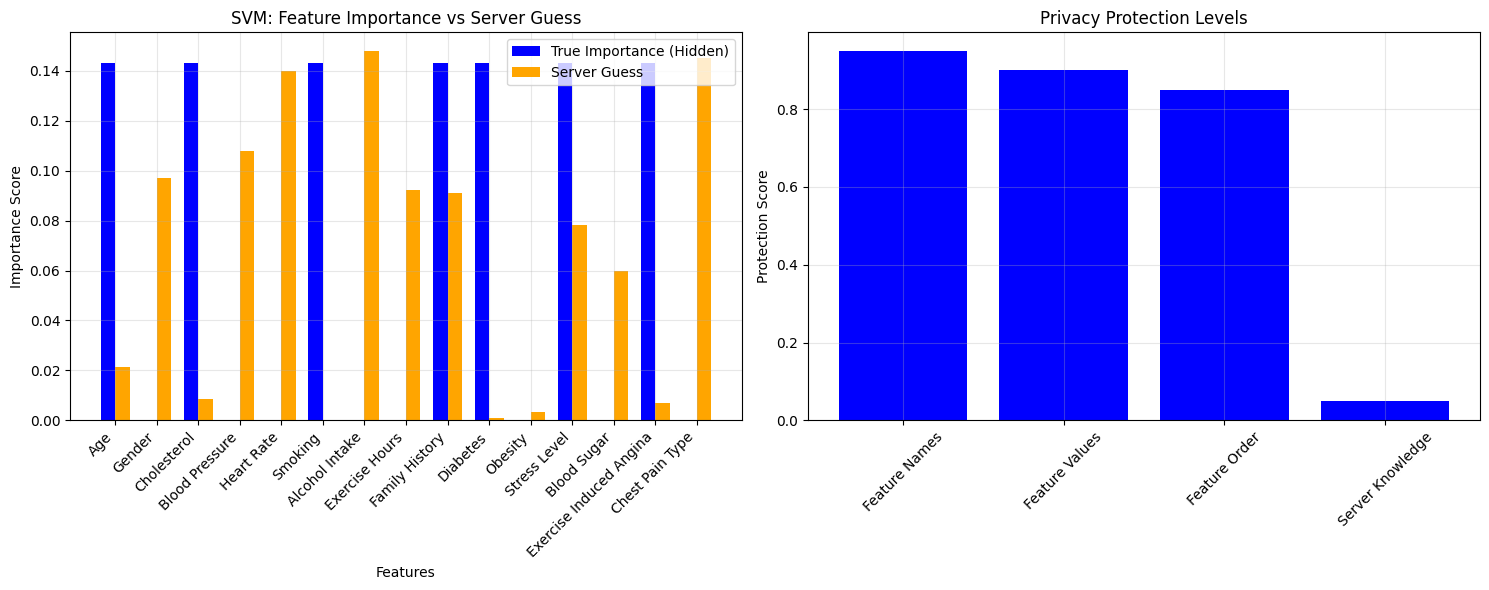

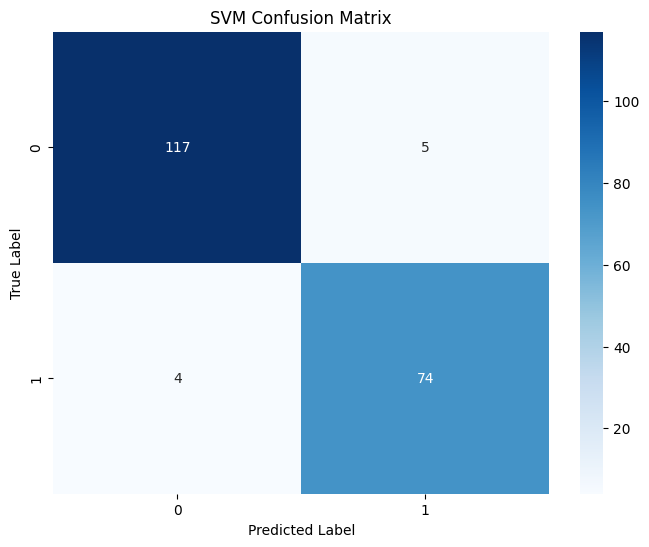


Evaluating Neural Network with 5-fold cross-validation:
Fold 1:
Train Accuracy: 0.9200
Test Accuracy: 0.8900
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       121
           1       0.88      0.84      0.86        79

    accuracy                           0.89       200
   macro avg       0.89      0.88      0.88       200
weighted avg       0.89      0.89      0.89       200

------------------------------
Fold 2:
Train Accuracy: 0.9812
Test Accuracy: 0.9600
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       121
           1       0.96      0.94      0.95        79

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200

------------------------------
Fold 3:
Train Accuracy: 0.9550
Test Accuracy: 0.9350
Classification Report:

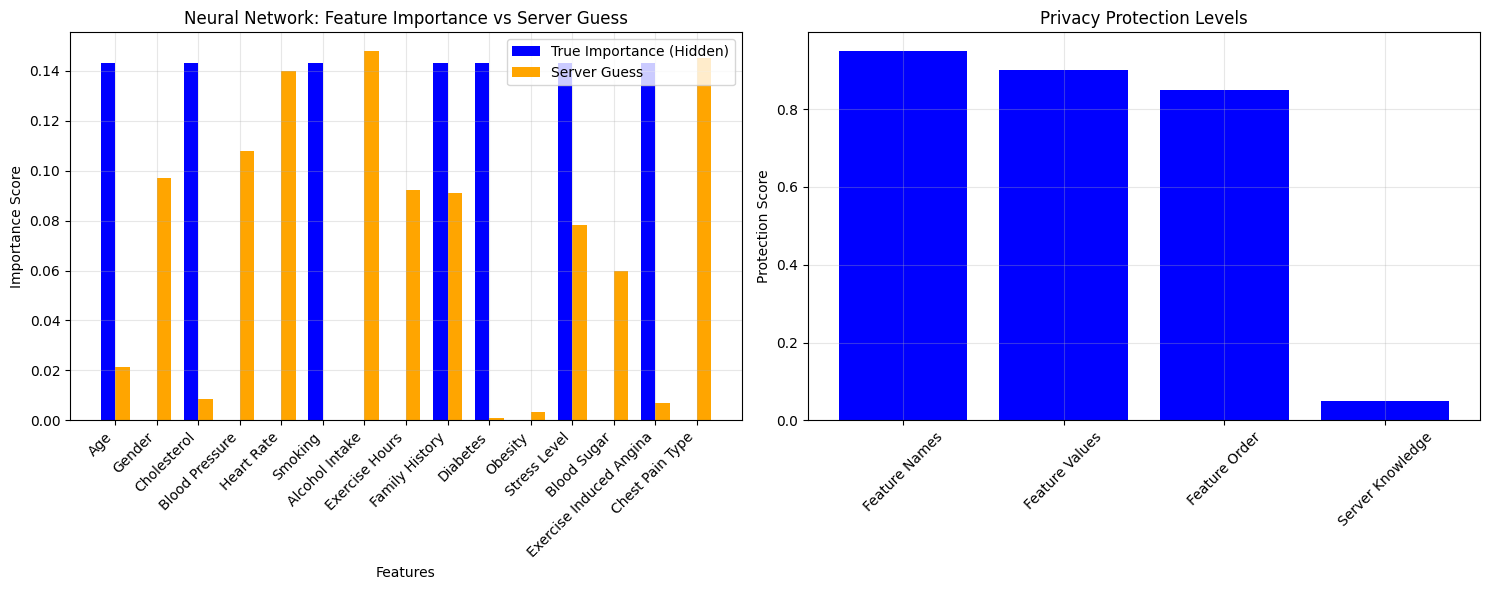

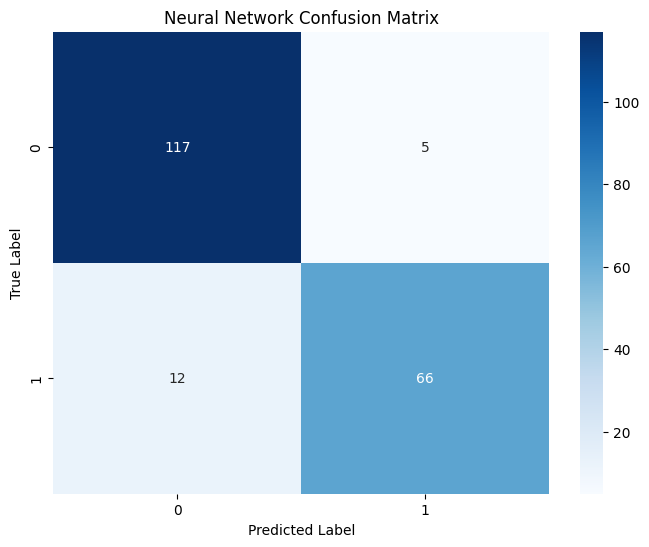


Evaluating XGBoost with 5-fold cross-validation:
Fold 1:
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       1.00      1.00      1.00        79

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

------------------------------
Fold 2:
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       1.00      1.00      1.00        79

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

------------------------------
Fold 3:
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Classification Report:
      

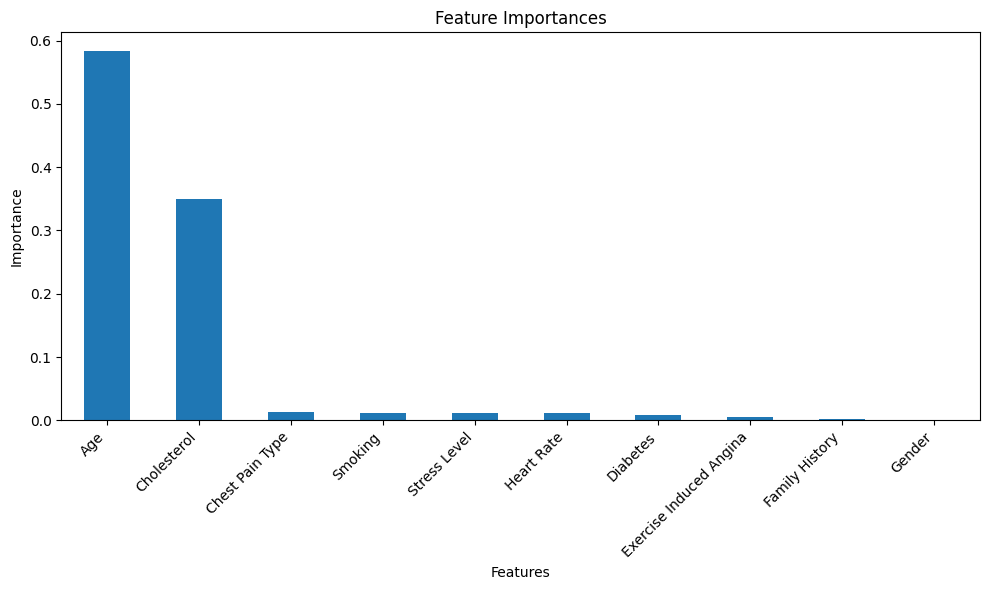

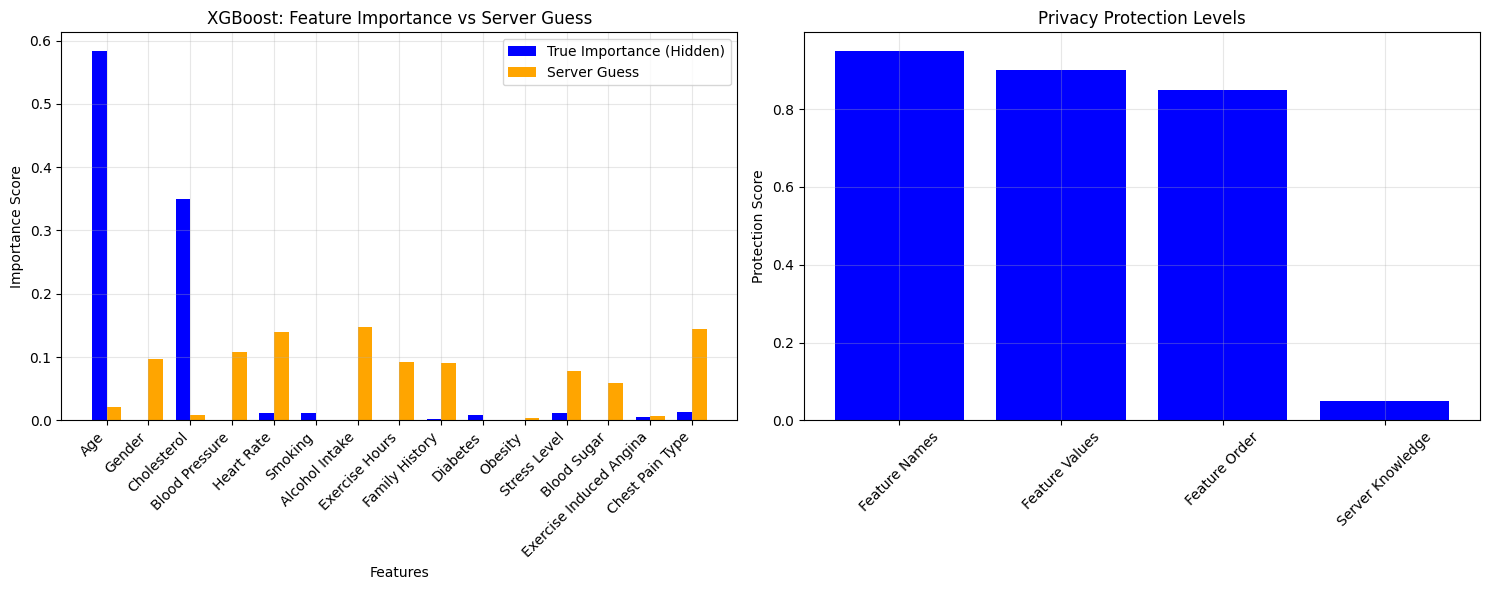

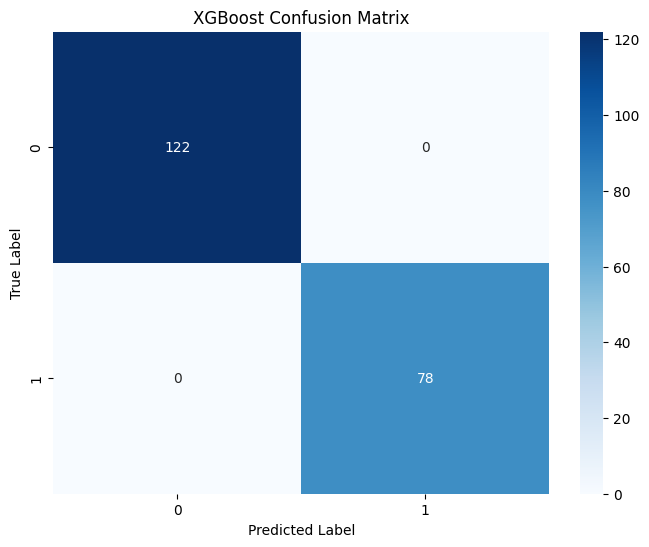

In [30]:
def preprocess_data(data):
    """Preprocess the data with stable scaling"""
    categorical_features = [
        'Gender', 'Smoking', 'Alcohol Intake', 'Family History',
        'Diabetes', 'Obesity', 'Exercise Induced Angina', 'Chest Pain Type'
    ]

    numerical_features = [
        'Age', 'Cholesterol', 'Blood Pressure', 'Heart Rate',
        'Exercise Hours', 'Stress Level', 'Blood Sugar'
    ]

    processed_data = data.copy()

    # Encode categorical variables
    for feature in categorical_features:
        if feature in processed_data.columns:
            processed_data[feature] = pd.Categorical(processed_data[feature]).codes

    # Scale numerical features
    scaler = StandardScaler()
    if all(feature in processed_data.columns for feature in numerical_features):
        processed_data[numerical_features] = scaler.fit_transform(processed_data[numerical_features])

    return processed_data

def main():
    # Set random seed for reproducibility
    np.random.seed(42)
    random.seed(42)

    try:
        print("Please upload your heart disease dataset (CSV file)...")
        uploaded = files.upload()

        file_name = next(iter(uploaded))
        data = pd.read_csv(io.BytesIO(uploaded[file_name]))

        print("\nDataset loaded successfully!")
        print(f"Shape of dataset: {data.shape}")

        # Preprocess data
        processed_data = preprocess_data(data)

        # Prepare features and target
        X = processed_data.drop('Heart Disease', axis=1).values
        y = processed_data['Heart Disease'].values

        # Get feature names
        feature_names = processed_data.drop('Heart Disease', axis=1).columns.tolist()

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Initialize models
        n_features = X.shape[1]
        models = {
            'SVM': PrivateSVM(n_features),
            'Neural Network': PrivateNeuralNetwork(n_features),
            'XGBoost': PrivateXGBoost(n_features)
        }

        # Evaluate each model with cross-validation
        for model_name, model in models.items():
            print(f"\nEvaluating {model_name} with 5-fold cross-validation:")
            print("=" * 50)

            cv_results = evaluate_model_with_cv(model, X, y)

            print(f"\n{model_name} Final Results:")
            print(f"Average Train Accuracy: {cv_results['train_mean']:.4f} ± {cv_results['train_std']:.4f}")
            print(f"Average Test Accuracy: {cv_results['test_mean']:.4f} ± {cv_results['test_std']:.4f}")

            # Train final model
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )

            model.train_privately(X_train, y_train)
            y_pred = model.predict(X_test)

            # Visualize feature importance for XGBoost
            if isinstance(model, PrivateXGBoost):
                visualize_feature_importance(model, feature_names)

            # Visualize privacy metrics
            PrivacyVisualizer.visualize_feature_privacy(
                X, model, model_name, feature_names
            )

            # Plot confusion matrix
            conf_matrix = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(
                conf_matrix,
                annot=True,
                fmt='d',
                cmap='Blues'
            )
            plt.title(f'{model_name} Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    main()